In [1]:
import numpy as np
from polyphys.probe.prober import fsd
from polyphys.analyze import correlations
import MDAnalysis as mda
from MDAnalysis.analysis.base import AnalysisFromFunction
from MDAnalysis import transformations as mda_trans

from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
glob('./N*gyrTDna.txt')

['./N1000epshm29kbmm25nh0ac1nc0l500dt0.005ndump2000adump5000ens1.gyrTDna.txt']

In [4]:
#short = np.loadtxt('./N200dt0.005ndump2000adump5000kbmm1r9lz45nh0ac1nc0ens1.gyrTDna.txt')
long = np.loadtxt('./N1000epshm29kbmm25nh0ac1nc0l500dt0.005ndump2000adump5000ens1.gyrTDna.txt')

In [5]:
len(long)

100020

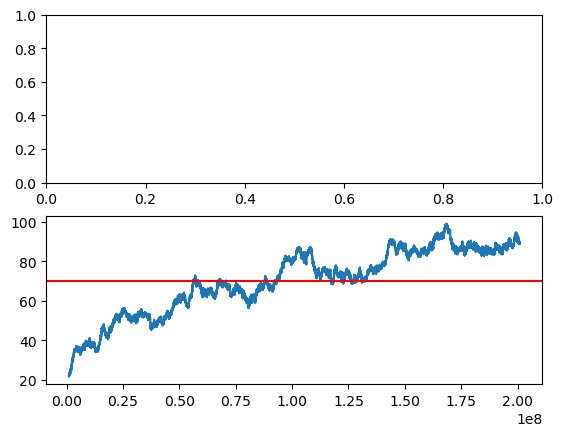

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=1)

#ax[0].plot(short[:,0],short[:,1])
#short_mean = np.mean(short[:,1])
#ax[0].axhline(y=short_mean,c='red')
long_mean = np.mean(long[:,1])
ax[1].plot(long[:,0],long[:,1])
ax[1].axhline(y=long_mean,c='red')
plt.show()

In [ ]:
glob('./N*')

In [2]:
cell = mda.Universe(
    './N1000dt0.005ndump2000adump5000kbmm25r7.5lz600nh0ac1nc0ens1.ring.all.data',
    './N1000dt0.005ndump2000adump5000kbmm25r7.5lz600nh0ac1nc0ens1.ring.nucleoid.lammpstrj',
    topology_format='DATA',
    format='LAMMPSDUMP',
    lammps_coordinate_convention='unscaled',
    unwrap_images=False,
    atom_style="id resid type x y z", 
    dt=2000*0.005
)

In [3]:
bug = cell.select_atoms('resid 1')  # the bug

In [ ]:
workflow = [
        mda_trans.unwrap(cell.atoms),
        mda_trans.center_in_box(bug),
        mda_trans.wrap(cell.atoms)
    ]
cell.trajectory.add_transformations(*workflow)

In [ ]:
bug.atoms.n_atoms

In [49]:
fsd_t = np.empty(0)
n_bonds = len(bug.bonds.indices)
bond_lengths = np.zeros((n_bonds, 1), dtype=np.float64)
cosine_corrs = np.zeros(n_bonds, dtype=np.float64)

In [50]:
%%time

for _ in cell.trajectory[80000:]:
    # bug:
    # -various measures of chain size
    bond_dummy, cosine_dummy = correlations.bond_info(
        bug,
        'ring'
        )
    bond_lengths += bond_dummy
    cosine_corrs += cosine_dummy
    fsd_t = np.append(fsd_t, np.array([fsd(bug.positions)]), axis=0)

CPU times: user 2min 18s, sys: 9.81 s, total: 2min 28s
Wall time: 1min 12s


In [51]:
n_frames = len(cell.trajectory[80000:])
n_frames

20001

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)

ax[0].plot(0.005*long[:-19,0],long[:-19,1])
short_mean = np.mean(long[55000:,1])
ax[0].axhline(y=short_mean,c='red',label=fr'$\langle R_g\rangle={round(short_mean,3)}$')
ax[0].axvline(x=0.005*long[55000,0],c='gray',ls='--',label='Equilibrium reached!')
ax[0].legend()
ax[0].set_ylabel(r'$R_g(t)$')
fsd_mean = np.mean(fsd_t[55000:])
ax[1].plot(0.005*long[:-19,0],fsd_t)
ax[1].axhline(y=fsd_mean,c='red',label=fr'$\langle L\rangle={round(fsd_mean,3)}$')
ax[1].axvline(x=0.005*long[55000,0],c='gray',ls='--',label='Equilibrium reached!')
ax[1].set_ylabel(r'$L$')
ax[1].legend()
ax[1].set_xlabel(r'$t/\tau_{LJ}$')
plt.show()
fig.savefig('chainsize.pdf')

In [36]:
import scipy
def fit_exponential_decay(x, y):
    r"""Fit a function to an exponential decay

    .. math::  y = \exp\left(- \frac{x}{a}\right)

    Parameters
    ----------
    x, y : array_like
      The two arrays of data

    Returns
    -------
    a : float
      The coefficient *a* for this decay

    Notes
    -----
    This function assumes that data starts at 1.0 and decays to 0.0

    """
    def exp_func(x, a):
        return np.exp(-x/a)
    a = scipy.optimize.curve_fit(exp_func, x, y)[0][0]
    return a
def fit_exponential_growth(x, y):
    r"""Fit a function to an exponential decay

    .. math::  y = \exp\left(- \frac{x}{a}\right)

    Parameters
    ----------
    x, y : array_like
      The two arrays of data

    Returns
    -------
    a : float
      The coefficient *a* for this decay

    Notes
    -----
    This function assumes that data starts at 1.0 and decays to 0.0

    """
    def exp_func(x, a):
        return np.exp(x/a)
    a = scipy.optimize.curve_fit(exp_func, x, y)[0][0]
    return a

In [52]:
bond_lengths_2 = bond_lengths / n_frames
bonds_per_lag = np.arange(n_bonds, 0, -1)
cosine_corrs_2 = cosine_corrs / (n_frames * bonds_per_lag)
bond_lengths_2 = bond_lengths_2.reshape(n_bonds,)

In [53]:
mean_bond = np.mean(bond_lengths_2)
mean_bond

0.9700617340926706

In [54]:
bond_lags = np.arange(1, n_bonds+1)

In [55]:
per_length = fit_exponential_decay(
    bond_lags,
    cosine_corrs_2
)

In [56]:
per_length

112.9446326582935

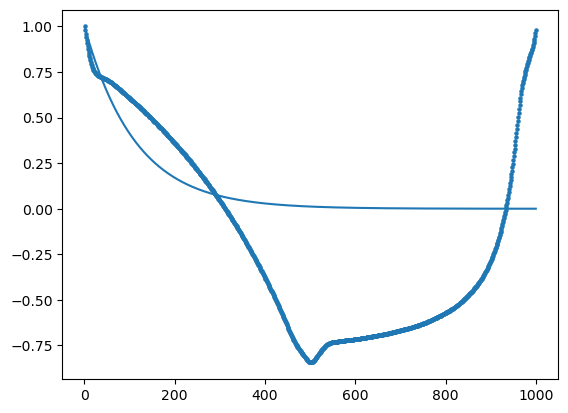

In [57]:
fig, ax = plt.subplots()

ax.scatter(bond_lags,cosine_corrs_2,marker='o',s=5)
ax.plot(bond_lags,np.exp(-bond_lags/per_length))
#short_mean = np.mean(long[55000:,1])
#ax.axhline(y=short_mean,c='red',label=fr'$\langle R_g\rangle={round(short_mean,3)}$')
#ax.axvline(x=0.005*long[55000,0],c='gray',ls='--',label='Equilibrium reached!')
#ax.legend()
#ax.set_ylabel(r'$R_g(t)$')

plt.show()
fig.savefig('bond_correlations.pdf')